In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm 
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


# 1. 데이터 로드
data = pd.read_csv('data/5528_12count/inter/5528_inter_imbalance_normal.csv')
e_data = pd.read_csv('data/5528_12count/inter/5528_inter_imbalance_error.csv')

# 2. null값 처리
data = data.dropna()

# 데이터의 시간 정보를 사용하여 훈련 데이터와 테스트 데이터 나누기
# created_at 유닉스 시간대 컬럼을 기준으로 시계열 정렬
data['created_at'] = pd.to_datetime(data['created_at'], unit='s')
data = data.sort_values(by='created_at')

e_data['created_at'] = pd.to_datetime(e_data['created_at'], unit='s')
e_data = e_data.sort_values(by='created_at')

# 훈련 데이터와 테스트 데이터 분할
train_data = data
test_data = e_data

In [2]:
train_data.head

<bound method NDFrame.head of                                   asset_id          created_at  \
0     55285839-9b78-48d8-9f4e-573190ace016 2024-01-09 15:47:44   
1     55285839-9b78-48d8-9f4e-573190ace016 2024-01-09 17:47:53   
2     55285839-9b78-48d8-9f4e-573190ace016 2024-01-09 19:47:56   
3     55285839-9b78-48d8-9f4e-573190ace016 2024-01-09 21:48:05   
4     55285839-9b78-48d8-9f4e-573190ace016 2024-01-09 23:48:07   
...                                    ...                 ...   
2311  55285839-9b78-48d8-9f4e-573190ace016 2024-08-25 06:50:16   
2312  55285839-9b78-48d8-9f4e-573190ace016 2024-08-25 08:50:24   
2313  55285839-9b78-48d8-9f4e-573190ace016 2024-08-25 10:50:26   
2314  55285839-9b78-48d8-9f4e-573190ace016 2024-08-25 12:50:35   
2315  55285839-9b78-48d8-9f4e-573190ace016 2024-08-25 14:50:37   

     created_at_datetime     rms_x     rms_y     rms_z   rms_xyz  vel_rms_x  \
0        2024-01-10 0:47  0.015930  0.017679  0.019701  0.030894   0.201879   
1        2024-01-10

In [3]:
# 3. 필요한 특성 선택
train_features = train_data.drop(columns=['asset_id', 'created_at', 'created_at_datetime', 'looseness_health', 'time','misalignment_health', 'bearing_health', 'imbalance_health'])
test_features = test_data.drop(columns=['asset_id', 'created_at', 'created_at_datetime', 'looseness_health', 'time','misalignment_health', 'bearing_health', 'imbalance_health'])

# train_features = train_features.loc[:,['vel_crest_factor_x', 'rms_x', 'vel_kurtosis_y','vel_kurtosis_z', 'vel_peak_z','skewness_y','crest_factor_y','vel_skewness_x','vel_rms_xyz','peak_y','peak_x']]
# test_features = test_features.loc[:,['vel_crest_factor_x', 'rms_x', 'vel_kurtosis_y','vel_kurtosis_z', 'vel_peak_z','skewness_y','crest_factor_y','vel_skewness_x','vel_rms_xyz','peak_y','peak_x']]

In [4]:
train_features.columns.to_list()

['rms_x',
 'rms_y',
 'rms_z',
 'rms_xyz',
 'vel_rms_x',
 'vel_rms_y',
 'vel_rms_z',
 'vel_rms_xyz',
 'skewness_x',
 'skewness_y',
 'skewness_z',
 'vel_skewness_x',
 'vel_skewness_y',
 'vel_skewness_z',
 'kurtosis_x',
 'kurtosis_y',
 'kurtosis_z',
 'vel_kurtosis_x',
 'vel_kurtosis_y',
 'vel_kurtosis_z',
 'crest_factor_x',
 'crest_factor_y',
 'crest_factor_z',
 'vel_crest_factor_x',
 'vel_crest_factor_y',
 'vel_crest_factor_z',
 'peak_x',
 'peak_y',
 'peak_z',
 'vel_peak_x',
 'vel_peak_y',
 'vel_peak_z',
 'peak2peak_x',
 'peak2peak_y',
 'peak2peak_z',
 'vel_peak2peak_x',
 'vel_peak2peak_y',
 'vel_peak2peak_z']

In [5]:
train_features.shape , test_features.shape

((2316, 38), (192, 38))

In [6]:
class LSTMAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=10):
        super(LSTMAutoencoder, self).__init__()
        self.encoder = nn.LSTM(
            input_size=n_features,
            hidden_size=embedding_dim,
            num_layers=1,
            batch_first=True
        )
        self.decoder = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=n_features,
            num_layers=1,
            batch_first=True
        )

    def forward(self, x):
        # Encoder
        _, (hidden_n, _) = self.encoder(x)
        
        # Decoder
        decoder_input = hidden_n.repeat(x.size(1), 1, 1).permute(1, 0, 2)
        decoder_output, _ = self.decoder(decoder_input)
        
        return decoder_output

# 모델 초기화
seq_len = 12  # 시퀀스 길이
n_features = 38  # 특성 수
model = LSTMAutoencoder(seq_len, n_features)

In [7]:
# 슬라이딩 윈도우 생성 시 12칸씩 슬라이딩 하려면 사용할 것
# train_features = train_features[:2004]
# test_features = test_features[:492]

In [8]:
# 4. 정규화
scaler = MinMaxScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features) # 테스트 데이터는 fit하면 안됨

# 5. 슬라이딩 윈도우 생성
window_size = seq_len # 2시간 단위를 하루 단위의 status 지표에 맞추기 위해 12 사용
def create_windows(data, window_size):
    # return [data[i:i+window_size] for i in range(len(data) - window_size + 1)] # 1칸씩 슬라이딩 (123, 234, 345 ...)
    return [data[i:i + window_size] for i in range(0, len(data), window_size)] # window_size 만큼 구분지어 슬라이딩 (123, 456, 789 ...)

def create_windows_for_test(data, window_size):
    # return [data[i:i+window_size] for i in range(len(data) - window_size + 1)] # 1칸씩 슬라이딩 (123, 234, 345 ...)
    return [data[i:i + window_size] for i in range(0, len(data), window_size)] # window_size 만큼 구분지어 슬라이딩 (123, 456, 789 ...)

train_windows = create_windows(train_features_scaled, window_size)
test_windows = create_windows_for_test(test_features_scaled, window_size)

# 6. PyTorch 텐서로 변환
train_windows_tensor = torch.tensor(np.array(train_windows), dtype=torch.float32)
test_windows_tensor = torch.tensor(np.array(test_windows), dtype=torch.float32)

In [9]:
train_windows_tensor.shape, test_windows_tensor.shape

(torch.Size([193, 12, 38]), torch.Size([16, 12, 38]))

In [10]:
# 7. 데이터셋 및 데이터로더 생성
train_dataset = TensorDataset(train_windows_tensor)
test_dataset = TensorDataset(test_windows_tensor)

train_dataloader = DataLoader(train_dataset, batch_size=12, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=12, shuffle=False)

In [11]:
# 손실 함수와 옵티마이저 정의
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

# 학습 루프
num_epochs = 100
best_loss = float('inf')
best_model_state = None

for epoch in tqdm(range(num_epochs)):
    epoch_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        outputs = model(batch[0])
        loss = criterion(outputs, batch[0])
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_dataloader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss}')

    # 최적 모델 업데이트
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_model_state = model.state_dict()  # 모델의 상태 저장

# 훈련 후 최적 모델 저장
if best_model_state is not None:
    torch.save(best_model_state, '0925_best_model_LSTM_AE.pth')


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Loss: 0.0741954938892056
Epoch 2/100, Loss: 0.05475095265051898
Epoch 3/100, Loss: 0.04092372931978282
Epoch 4/100, Loss: 0.03152835971730597
Epoch 5/100, Loss: 0.025396074004033032
Epoch 6/100, Loss: 0.022932068828274223
Epoch 7/100, Loss: 0.022481218528221634
Epoch 8/100, Loss: 0.020917885936796665
Epoch 9/100, Loss: 0.02042371965944767
Epoch 10/100, Loss: 0.020212806870832163
Epoch 11/100, Loss: 0.020578400724950957
Epoch 12/100, Loss: 0.019231137216967696
Epoch 13/100, Loss: 0.018988411928362706
Epoch 14/100, Loss: 0.01852990182883599
Epoch 15/100, Loss: 0.01816492640029858
Epoch 16/100, Loss: 0.018093900508521235
Epoch 17/100, Loss: 0.018774198149056995
Epoch 18/100, Loss: 0.018662925426136043
Epoch 19/100, Loss: 0.018795422004426226
Epoch 20/100, Loss: 0.01891420693958507
Epoch 21/100, Loss: 0.018576715525020573
Epoch 22/100, Loss: 0.018778123564141637
Epoch 23/100, Loss: 0.01783249225905713
Epoch 24/100, Loss: 0.017664515988572556
Epoch 25/100, Loss: 0.0183152266613

In [12]:
# 11. 모델 평가 (스코어링)
model.load_state_dict(torch.load('0925_best_model_LSTM_AE.pth'))
model.eval()

criterion = nn.MSELoss(reduction='none')
anomaly_scores = []

with torch.no_grad():
    for batch in test_dataloader:
        inputs = batch[0]
        outputs = model(inputs)
        
        # 재구성 오차로 이상점수 계산 (MSE Loss)
        batch_scores = criterion(outputs, inputs).mean(dim=(1,2))
        anomaly_scores.extend(batch_scores)

C:\Users\user\AppData\Local\Temp\ipykernel_2080\2688890986.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('0925_best_model_LSTM_AE.pth'

In [13]:
# 12. 임계값 계산
mean_score = np.mean(anomaly_scores)
std_score = np.std(anomaly_scores)

print(f'평균 스코어: {mean_score:.6f}')
print(f'표준편차: {std_score:.6f}')

# 임계값 설정 (평균 + 임의값 * 표준편차)
threshold = mean_score + 2.576 * std_score
print(f'임계값: {threshold:.6f}')

# 이상 점수 판별
anomalies = anomaly_scores > threshold
print(f'이상 점수 인덱스: {np.where(anomalies)[0]}')

평균 스코어: 0.016787
표준편차: 0.007320
임계값: 0.035643
이상 점수 인덱스: [13]


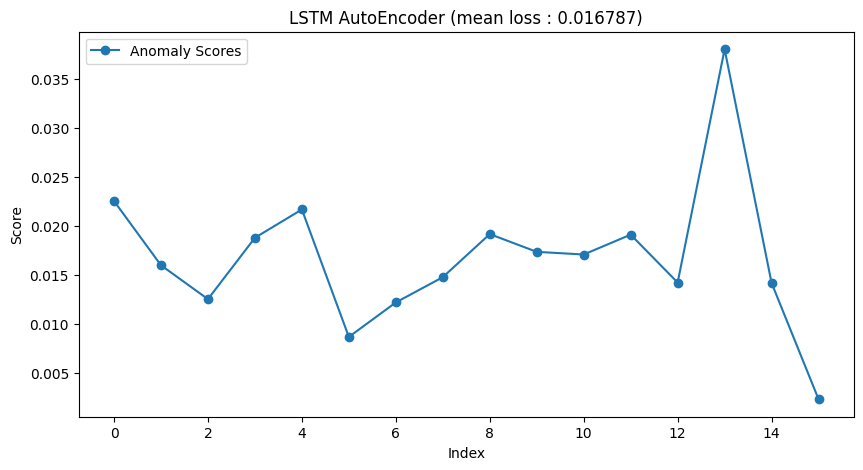

In [14]:
# 13. 인덱스 및 이상 점수 시각화
anomaly_indices = np.where(anomalies)[0]

plt.figure(figsize=(10, 5))
plt.plot(anomaly_scores, label='Anomaly Scores', marker='o')
# plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.xlabel('Index')
plt.ylabel('Score')
plt.title(f'LSTM AutoEncoder (mean loss : {format(mean_score, '.6f')})')
plt.legend()
plt.show()

In [15]:
# 이상탐지된 인덱스 비교용
test_data_result=test_data.reset_index(drop=True)
indices = np.where(anomalies)[0].tolist()
test_data_result.loc[indices]

# test_data_result.loc[indices].to_csv("anomaly_transformer_result.csv")


,asset_id,created_at,created_at_datetime,rms_x,rms_y,rms_z,rms_xyz,vel_rms_x,vel_rms_y,vel_rms_z,...,peak2peak_y,peak2peak_z,vel_peak2peak_x,vel_peak2peak_y,vel_peak2peak_z,time,imbalance_health,misalignment_health,looseness_health,bearing_health
13,55285839-9b78-48d8-9f4e-573190ace016,2024-01-12 17:55:40,2024-01-13 2:55,0.012003,0.014829,0.018606,0.026649,0.236908,0.386276,0.32377,...,0.105469,0.152344,1.73793,1.97696,1.56504,2024-01-14 0:00,0.878773,0.98,0.98,1
